# SAC vs GRPO on MountainCarContinuous-v0

## Introduction

This notebook compares two reinforcement learning algorithms on the **MountainCarContinuous-v0** environment:

- **SAC (Soft Actor-Critic)**: A popular policy gradient method from `stable-baselines3` that uses a value function (critic) and clipped policy gradients for stable training.

- **GRPO (Group Relative Policy Optimization)**: An algorithm implemented in this repository (`sb3_contrib`) that uses relative performance within a group instead of a learned value function. GRPO normalizes advantages within groups of samples, providing stable gradient estimates without the need for a critic network.

### Environment: MountainCarContinuous-v0
The goal is to drive an underpowered car up a steep hill. The car must build momentum by rocking back and forth. The state space includes position and velocity, and the action is a continuous force applied to the car.

### Outcome
By the end of this notebook, you will see:
1. Training curves comparing episodic rewards for SAC and GRPO
2. A side-by-side video of both trained agents for direct visual comparison

## 1) Setup and Imports

In [1]:
import os
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# stable-baselines3 imports
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

# sb3_contrib imports (GRPO from this repository)
from sb3_contrib import GRPO

# TensorBoard logging
from torch.utils.tensorboard import SummaryWriter

# Video recording
from gymnasium.wrappers import RecordVideo

# Video composition (moviepy 2.x uses moviepy.video.io instead of moviepy.editor)
try:
    from moviepy.editor import VideoFileClip, clips_array
except ImportError:
    # For moviepy 2.x
    from moviepy import VideoFileClip, concatenate_videoclips

# For displaying video in notebook
from IPython.display import HTML



2025-12-05 20:54:03.333172: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-05 20:54:03.372848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 20:54:04.307656: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical 

In [2]:
# Print versions for reproducibility
import stable_baselines3
import sb3_contrib

print(f"gymnasium version: {gym.__version__}")
print(f"stable-baselines3 version: {stable_baselines3.__version__}")
print(f"sb3_contrib version: {sb3_contrib.__version__}")

gymnasium version: 1.2.2
stable-baselines3 version: 2.7.0
sb3_contrib version: 2.7.1a3


## 2) Environment Helpers

In [3]:
from typing import List, Optional


def make_env(seed: Optional[int] = None) -> gym.Env:
    """
    Create a MountainCarContinuous-v0 environment.
    
    Args:
        seed: Optional random seed for reproducibility.
        
    Returns:
        The created gymnasium environment.
    """
    env = gym.make("MountainCarContinuous-v0")
    if seed is not None:
        env.reset(seed=seed)
    return env

## 3) Training Configuration

In [4]:
# Training configuration
# MountainCarContinuous-v0 - SAC is more sample-efficient than on-policy methods
TOTAL_TIMESTEPS = 200_000  # 2M timesteps for fair comparison
SEED = 0                      # Random seed for reproducibility
N_EVAL_EPISODES = 10          # Number of episodes for final evaluation
VIDEO_EPISODES = 1            # Number of episodes to record for video

# SAC hyperparameters (from rl_zoo3 command)
# Off-policy algorithm with replay buffer and entropy regularization
SAC_PARAMS = {
    'learning_rate': 3e-4,      # Standard SAC learning rate
    'gamma': 0.9999,            # Very high discount for long-horizon planning
    'batch_size': 512,          # Large batches from replay buffer
    'buffer_size': 50000,       # Replay buffer size
    'gradient_steps': 32,       # Gradient steps per environment step
    'train_freq': 32,           # Train every 32 steps
    'tau': 0.01,                # Soft update coefficient for target networks
    'ent_coef': 0.1,            # Entropy regularization coefficient
}

# GRPO hyperparameters adapted for comparison with SAC
# On-policy algorithm - needs to match SAC's performance
GRPO_PARAMS = {
    'learning_rate': 3e-4,      # Match SAC learning rate
    'n_steps': 2048,            # Larger rollouts for better sample efficiency
    'batch_size': 512,          # Match SAC batch size
    'gamma': 0.9999,            # Match SAC
    'group_size': 64,           # Larger groups for stable relative advantages
    'kl_coef': 0.05,            # KL divergence regularization
    'clip_range': 0.2,          # Policy clipping
    'max_grad_norm': 0.5,       # Gradient clipping
    'n_epochs': 10,             # Multiple epochs per rollout
}

# Ensure output directories exist
os.makedirs('examples/models', exist_ok=True)
os.makedirs('examples/videos', exist_ok=True)
os.makedirs('/tmp/tensorboard_logs', exist_ok=True)

print(f'Training for {TOTAL_TIMESTEPS:,} timesteps')
print(f'SAC params: lr={SAC_PARAMS["learning_rate"]}, batch={SAC_PARAMS["batch_size"]}, buffer={SAC_PARAMS["buffer_size"]}, gamma={SAC_PARAMS["gamma"]}')
print(f'GRPO params: lr={GRPO_PARAMS["learning_rate"]}, n_steps={GRPO_PARAMS["n_steps"]}, batch={GRPO_PARAMS["batch_size"]}, gamma={GRPO_PARAMS["gamma"]}')

Training for 200,000 timesteps
SAC params: lr=0.0003, batch=512, buffer=50000, gamma=0.9999
GRPO params: lr=0.0003, n_steps=2048, batch=512, gamma=0.9999


## 4) Callback for Logging Training Rewards

We create a simple callback to track episodic rewards during training.

In [5]:
class RewardLoggerCallback(BaseCallback):
    """
    Callback for logging episode rewards during training.
    """
    
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards: List[float] = []
        self.episode_lengths: List[int] = []
        self.timesteps: List[int] = []
        
    def _on_step(self) -> bool:
        # Check if any episode has finished
        if self.locals.get("infos"):
            for info in self.locals["infos"]:
                if "episode" in info:
                    self.episode_rewards.append(info["episode"]["r"])
                    self.episode_lengths.append(info["episode"]["l"])
                    self.timesteps.append(self.num_timesteps)
        return True

## 5) Training SAC Baseline

**SAC (Soft Actor-Critic)** is a popular on-policy algorithm that:
- Uses a value function (critic) to estimate expected returns
- Uses clipped policy gradients to prevent large policy updates
- Is known for stable training across many environments

In [6]:
# Create environment with Monitor wrapper to track episode stats
sac_env = Monitor(make_env(SEED))

# Create SAC model with tuned hyperparameters
sac_model = SAC(
    'MlpPolicy',
    sac_env,
    seed=SEED,
    verbose=0,
    tensorboard_log='/tmp/tensorboard_logs',
    **SAC_PARAMS,  # Apply tuned hyperparameters
)

print(f'SAC config: lr={sac_model.learning_rate}, n_steps={sac_model.n_steps}, batch={sac_model.batch_size}, gamma={sac_model.gamma}')

# Create callback for logging rewards
sac_callback = RewardLoggerCallback()

# Train SAC
print('\nTraining SAC...')
sac_model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=sac_callback,
    progress_bar=True,
    tb_log_name='SAC',  # This creates SAC_1, SAC_2, etc.
)

# Save the trained model
sac_model.save('examples/models/sac_mountaincar')
print('SAC model saved to examples/models/sac_mountaincar.zip')

Output()

SAC config: lr=0.0003, n_steps=1, batch=512, gamma=0.9999

Training SAC...


SAC model saved to examples/models/sac_mountaincar.zip


In [7]:
# Evaluate SAC
sac_eval_env = make_env(SEED + 100)  # Different seed for evaluation
sac_mean_reward, sac_std_reward = evaluate_policy(
    sac_model, sac_eval_env, n_eval_episodes=N_EVAL_EPISODES, deterministic=True
)
print(f"SAC Evaluation: Mean reward = {sac_mean_reward:.2f} +/- {sac_std_reward:.2f}")
sac_eval_env.close()

# Store training rewards for plotting
sac_rewards = np.array(sac_callback.episode_rewards)
sac_timesteps = np.array(sac_callback.timesteps)

/home/rainer/anaconda3/envs/rlracing/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  if not is_monitor_wrapped and warn:


SAC Evaluation: Mean reward = -0.02 +/- 0.01


## 6) Training GRPO

**GRPO (Group Relative Policy Optimization)** is an algorithm that:
- Uses relative performance within a group instead of a learned value function
- Normalizes advantages within groups of samples for stable gradient estimates
- Reduces computational overhead by eliminating the critic network
- Uses KL divergence regularization to prevent policy collapse

In [8]:
# Create environment with Monitor wrapper to track episode stats
grpo_env = Monitor(make_env(SEED))

# Create GRPO model with tuned hyperparameters
grpo_model = GRPO(
    'MlpPolicy',
    grpo_env,
    seed=SEED,
    verbose=0,
    tensorboard_log='/tmp/tensorboard_logs',
    **GRPO_PARAMS,  # Apply tuned hyperparameters
)

print(f'GRPO config: lr={grpo_model.learning_rate}, n_steps={grpo_model.n_steps}, batch={grpo_model.batch_size}, gamma={grpo_model.gamma}')

# Create callback for logging rewards
grpo_callback = RewardLoggerCallback()

# Train GRPO
print('\nTraining GRPO...')
grpo_model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=grpo_callback,
    progress_bar=True,
    tb_log_name='GRPO',  # This creates GRPO_1, GRPO_2, etc.
)

# Save the trained model
grpo_model.save('examples/models/grpo_mountaincar')
print('GRPO model saved to examples/models/grpo_mountaincar.zip')

Output()

GRPO config: lr=0.0003, n_steps=2048, batch=512, gamma=0.9999

Training GRPO...


/home/rainer/anaconda3/envs/rlracing/lib/python3.11/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run GRPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


GRPO model saved to examples/models/grpo_mountaincar.zip


In [9]:
# Evaluate GRPO
grpo_eval_env = make_env(SEED + 100)  # Different seed for evaluation
grpo_mean_reward, grpo_std_reward = evaluate_policy(
    grpo_model, grpo_eval_env, n_eval_episodes=N_EVAL_EPISODES, deterministic=True
)
print(f"GRPO Evaluation: Mean reward = {grpo_mean_reward:.2f} +/- {grpo_std_reward:.2f}")
grpo_eval_env.close()

# Store training rewards for plotting
grpo_rewards = np.array(grpo_callback.episode_rewards)
grpo_timesteps = np.array(grpo_callback.timesteps)

GRPO Evaluation: Mean reward = -0.02 +/- 0.00


## 7) Training Curve Comparison

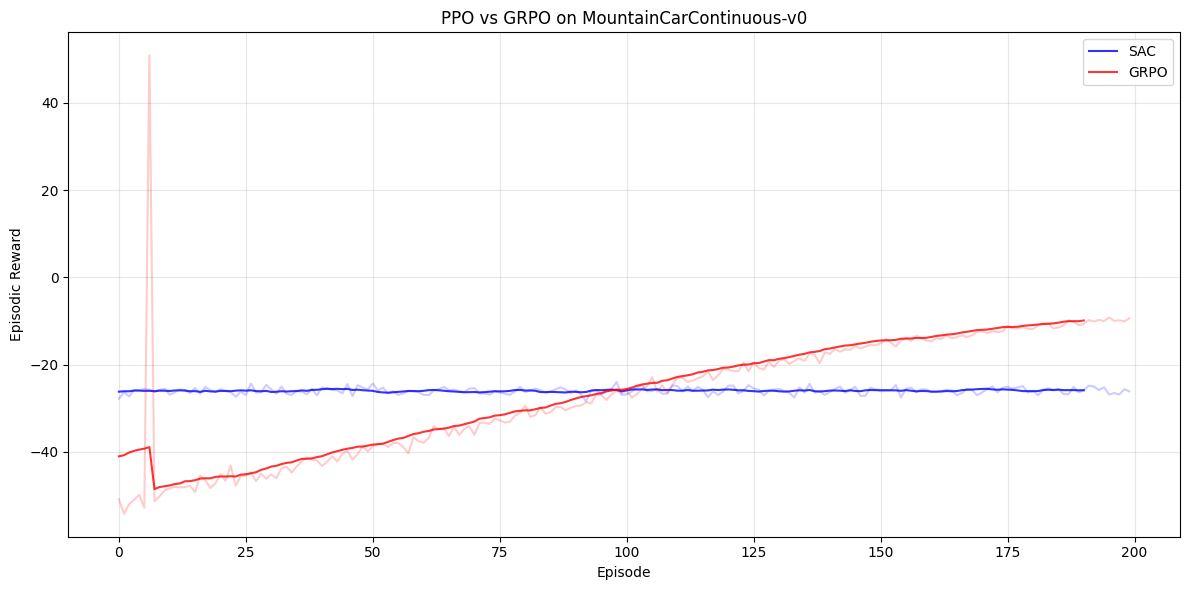

In [11]:
def smooth_rewards(rewards: np.ndarray, window: int = 10) -> np.ndarray:
    """
    Apply a simple moving average to smooth reward curves.
    
    Args:
        rewards: Array of episode rewards.
        window: Window size for moving average.
        
    Returns:
        Smoothed rewards array.
    """
    if len(rewards) < window:
        return rewards
    return np.convolve(rewards, np.ones(window) / window, mode="valid")


# Create figure for comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot PPO training curve
if len(sac_rewards) > 0:
    sac_smoothed = smooth_rewards(sac_rewards)
    ax.plot(
        range(len(sac_smoothed)),
        sac_smoothed,
        label="SAC",
        color="blue",
        alpha=0.8,
    )
    # Plot raw rewards with transparency
    ax.plot(
        range(len(sac_rewards)),
        sac_rewards,
        color="blue",
        alpha=0.2,
    )

# Plot GRPO training curve
if len(grpo_rewards) > 0:
    grpo_smoothed = smooth_rewards(grpo_rewards)
    ax.plot(
        range(len(grpo_smoothed)),
        grpo_smoothed,
        label="GRPO",
        color="red",
        alpha=0.8,
    )
    # Plot raw rewards with transparency
    ax.plot(
        range(len(grpo_rewards)),
        grpo_rewards,
        color="red",
        alpha=0.2,
    )

ax.set_xlabel("Episode")
ax.set_ylabel("Episodic Reward")
ax.set_title("PPO vs GRPO on MountainCarContinuous-v0")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8) Video Recording and Side-by-Side Visualization

Now we record videos of both trained agents and create a side-by-side comparison.

In [12]:
def record_video(model, model_name: str, video_dir: str) -> str:
    """
    Record a video of the trained agent.
    
    Args:
        model: The trained RL model.
        model_name: Name of the model (for file naming).
        video_dir: Directory to save the video.
        
    Returns:
        Path to the recorded video file.
    """
    # Create video directory
    video_folder = os.path.join(video_dir, model_name)
    os.makedirs(video_folder, exist_ok=True)
    
    # Create environment with video recorder
    env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=video_folder,
        episode_trigger=lambda x: True,  # Record all episodes
        name_prefix=model_name,
    )
    
    # Run episodes
    for episode in range(VIDEO_EPISODES):
        obs, info = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
    
    env.close()
    
    # Find the generated video file
    video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]
    if video_files:
        return os.path.join(video_folder, video_files[0])
    return ""

In [14]:
# Record videos for both models
print("Recording SAC video...")
sac_video_path = record_video(sac_model, "sac_mountaincar", "examples/videos")
print(f"SAC video saved to: {sac_video_path}")

print("\nRecording GRPO video...")
grpo_video_path = record_video(grpo_model, "grpo_mountaincar", "examples/videos")
print(f"GRPO video saved to: {grpo_video_path}")

Recording SAC video...


/home/rainer/anaconda3/envs/rlracing/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/rainer/pr/github/stable-baselines3-contrib/examples/examples/videos/sac_mountaincar folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/rainer/anaconda3/envs/rlracing/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


SAC video saved to: examples/videos/sac_mountaincar/sac_mountaincar-episode-0.mp4

Recording GRPO video...


/home/rainer/anaconda3/envs/rlracing/lib/python3.11/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /home/rainer/pr/github/stable-baselines3-contrib/examples/examples/videos/grpo_mountaincar folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


GRPO video saved to: examples/videos/grpo_mountaincar/grpo_mountaincar-episode-0.mp4


## 9) Side-by-Side Video Composition

Using moviepy, we create a side-by-side video comparison:
- **Left**: SAC agent
- **Right**: GRPO agent

This allows for direct visual comparison of how each algorithm solves the MountainCar task.

In [16]:
# Load the video clips
sac_clip = VideoFileClip(sac_video_path)
grpo_clip = VideoFileClip(grpo_video_path)

# Resize to same height if needed (moviepy 2.x uses resized method)
target_height = min(sac_clip.h, grpo_clip.h)
try:
    # moviepy 1.x
    sac_clip_resized = sac_clip.resize(height=target_height)
    grpo_clip_resized = grpo_clip.resize(height=target_height)
except AttributeError:
    # moviepy 2.x
    scale_sac = target_height / sac_clip.h
    scale_grpo = target_height / grpo_clip.h
    sac_clip_resized = sac_clip.resized(scale_sac)
    grpo_clip_resized = grpo_clip.resized(scale_grpo)

# Make clips the same duration (use the shorter one)
min_duration = min(sac_clip_resized.duration, grpo_clip_resized.duration)
try:
    # moviepy 1.x
    sac_clip_resized = sac_clip_resized.subclip(0, min_duration)
    grpo_clip_resized = grpo_clip_resized.subclip(0, min_duration)
except AttributeError:
    # moviepy 2.x
    sac_clip_resized = sac_clip_resized.subclipped(0, min_duration)
    grpo_clip_resized = grpo_clip_resized.subclipped(0, min_duration)

# Create side-by-side composition
try:
    # Try moviepy 1.x style
    from moviepy.editor import clips_array
    side_by_side = clips_array([[sac_clip_resized, grpo_clip_resized]])
except (ImportError, AttributeError):
    # For moviepy 2.x - create side by side manually
    from moviepy import CompositeVideoClip
    
    # Calculate total width
    total_width = sac_clip_resized.w + grpo_clip_resized.w
    
    # Position clips side by side
    side_by_side = CompositeVideoClip(
        [
            sac_clip_resized.with_position((0, 0)),
            grpo_clip_resized.with_position((sac_clip_resized.w, 0))
        ],
        size=(total_width, target_height)
    )

# Save the composite video
output_path = "examples/videos/ppo_vs_grpo_mountaincar_side_by_side.mp4"
side_by_side.write_videofile(output_path, fps=30, codec="libx264")

# Close clips
sac_clip.close()
grpo_clip.close()

print(f"\nSide-by-side video saved to: {output_path}")


MoviePy - Building video examples/videos/ppo_vs_grpo_mountaincar_side_by_side.mp4.
MoviePy - Writing video examples/videos/ppo_vs_grpo_mountaincar_side_by_side.mp4



MoviePy - Done !
MoviePy - video ready examples/videos/ppo_vs_grpo_mountaincar_side_by_side.mp4

Side-by-side video saved to: examples/videos/ppo_vs_grpo_mountaincar_side_by_side.mp4


## 10) Display Side-by-Side Video

The video below shows:
- **Left**: SAC agent solving MountainCarContinuous-v0
- **Right**: GRPO agent solving MountainCarContinuous-v0

In [17]:
# Display the side-by-side video in the notebook
video_html = f"""
<video width="800" controls>
    <source src="{output_path}" type="video/mp4">
    Your browser does not support the video tag.
</video>
"""

HTML(video_html)

## 11) View Results in TensorBoard

TensorBoard logs have been saved during training in `/tmp/tensorboard_logs/`.

### Option 1: Launch TensorBoard from terminal
```bash
tensorboard --logdir /tmp/tensorboard_logs
```
Then open your browser to http://localhost:6006

### Option 2: Launch TensorBoard in Jupyter (next cell)

### Run Organization:
- **SAC_1, SAC_2, ...**: SAC training runs
- **GRPO_1, GRPO_2, ...**: GRPO training runs

Each time you train, a new numbered run is created (e.g., SAC_1, SAC_2) so you can compare multiple training runs.

### Metrics Available:
- **rollout/ep_rew_mean**: Mean episode reward (should reach 90-100 for success)
- **rollout/ep_len_mean**: Mean episode length (should decrease from ~1000 to ~100-300)
- **train/learning_rate**: Learning rate over time
- **train/loss**: Policy and value losses
- **train/policy_gradient_loss**: Policy gradient loss
- **train/value_loss**: Value function loss (SAC only)

### Comparing SAC vs GRPO:
In TensorBoard, you can overlay the SAC and GRPO runs to directly compare:
- Training efficiency (how quickly rewards improve)
- Final performance (maximum achieved reward)
- Stability (variance in rewards over time)

**Tip**: Use the TensorBoard UI to select which runs to display (e.g., SAC_1 vs GRPO_1) for side-by-side comparison.

In [ ]:
# Launch TensorBoard in notebook (optional)
%load_ext tensorboard
%tensorboard --logdir /tmp/tensorboard_logs

## Summary

This notebook demonstrated a comparison between SAC and GRPO on the MountainCarContinuous-v0 environment.

### Key Differences:

| Aspect | SAC | GRPO |
|--------|-----|------|
| Value Function | Uses a learned critic | No critic needed |
| Advantage Estimation | GAE with value function | Group-relative normalization |
| Computational Cost | Higher (two networks) | Lower (single network) |
| Regularization | Clipped policy gradients | KL divergence + clipping |

### Files Generated:
- `examples/models/ppo_mountaincar.zip` - Trained SAC model
- `examples/models/grpo_mountaincar.zip` - Trained GRPO model
- `examples/videos/ppo_mountaincar/` - SAC agent video
- `examples/videos/grpo_mountaincar/` - GRPO agent video
- `examples/videos/ppo_vs_grpo_mountaincar_side_by_side.mp4` - Side-by-side comparison

In [19]:
# Cleanup: Close training environments
sac_env.close()
grpo_env.close()

print("All environments closed.")

All environments closed.


(rlracing) rainer@borg-mini:~/pr/github/stable-baselines3-contrib$ python -m rl_zoo3.train --algo ppo --env MountainCar-v0 -n 50000 -optimize --n-trials 1000 --n-jobs 2 --sampler random --pruner median
